In [1]:
import copy
import datetime as dt
from datetime import datetime
import importlib  # needed so that we can reload packages
import logging
import os
import pathlib
import sys
import time
import warnings
from typing import Union, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils.logger_utils import setup_clean_logger, mute_external_loggers

# SISEPUEDE imports
from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf
import sisepuede.core.attribute_table as att
import sisepuede.manager.sisepuede_examples as sxl
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.visualization.plots as svp

# --- Runtime configuration ---
warnings.filterwarnings("ignore")

# Set up a clean logger for your notebook
logger = setup_clean_logger("notebook", logging.INFO)
logger.info("Notebook started successfully.")

# Mute logs from sisepuede to avoid duplication
mute_external_loggers(["sisepuede"])


/Users/fabianfuentes/anaconda3/envs/ssp_mexico_nm/lib/python3.11/site-packages/munch/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-11-27 17:11:49,744 - INFO - Notebook started successfully.


In [2]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under ssp_modeling/config_files/config.yaml

You can also create a new config yaml



In [3]:
# Set up dir paths

CURR_DIR_PATH = pathlib.Path(os.getcwd())
SSP_MODELING_DIR_PATH = CURR_DIR_PATH.parent
PROJECT_DIR_PATH = SSP_MODELING_DIR_PATH.parent
DATA_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("input_data")
RUN_OUTPUT_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("ssp_run_output")
SCENARIO_MAPPING_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("scenario_mapping")
CONFIG_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("config_files")
TRANSFORMATIONS_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("transformations")
MISC_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("misc")
STRATEGIES_DEFINITIONS_FILE_PATH = TRANSFORMATIONS_DIR_PATH.joinpath("strategy_definitions.csv")
STRATEGY_MAPPING_FILE_PATH = MISC_DIR_PATH.joinpath("strategy_mapping.yaml")

In [4]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [5]:
# Load config file, double check your parameters are correct

YAML_FILE_PATH = os.path.join(CONFIG_DIR_PATH, "config.yaml")
config_params = g_utils.read_yaml(YAML_FILE_PATH)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']
set_lndu_reallocation_factor_to_zero_flag = config_params['set_lndu_reallocation_factor_to_zero']

# Print config parameters
logger.info(f"Country name: {country_name}")
logger.info(f"SSP input file name: {ssp_input_file_name}")
logger.info(f"SSP transformation CW: {ssp_transformation_cw}")
logger.info(f"Energy model flag: {energy_model_flag}")
logger.info(f"Set lndu reallocation factor to zero flag: {set_lndu_reallocation_factor_to_zero_flag}")

2025-11-27 17:11:49,822 - INFO - Country name: mexico
2025-11-27 17:11:49,823 - INFO - SSP input file name: sisepuede_raw_inputs_MEX_251112.csv
2025-11-27 17:11:49,823 - INFO - SSP transformation CW: ssp_mexico_transformation_cw.xlsx
2025-11-27 17:11:49,823 - INFO - Energy model flag: True
2025-11-27 17:11:49,823 - INFO - Set lndu reallocation factor to zero flag: True


In [6]:
def get_file_structure(
    y0: int = 2015,
    y1: int = 2050,
) -> Tuple[sfs.SISEPUEDEFileStructure, att.AttributeTable]:
    """Get the SISEPUEDE File Structure and update the attribute table
        with new years.
    """
    # setup some SISEPUEDE variables and update time period
    file_struct = sfs.SISEPUEDEFileStructure(
        initialize_directories = False,
    )
 
    # get some keys
    key_time_period = file_struct.model_attributes.dim_time_period
    key_year = file_struct.model_attributes.field_dim_year
 
 
    ##  BUILD THE ATTRIBUTE AND UPDATE
 
    # setup the new attribute table
    years = np.arange(y0, y1 + 1, ).astype(int)
    attribute_time_period = att.AttributeTable(
        pd.DataFrame(
            {
                key_time_period: range(len(years)),
                key_year: years,
            }
        ),
        key_time_period,
    )
 
    # finally, update the ModelAttributes inside the file structure
    (
        file_struct
        .model_attributes
        .update_dimensional_attribute_table(
            attribute_time_period,
        )
    )
 
    # return the tuple
    out = (file_struct, attribute_time_period, )
 
    return out
 
# # setup models
# models = sm.SISEPUEDEModels(
#     matt,
#     allow_electricity_run = True,
#     fp_julia = _FILE_STRUCTURE.dir_jl,
#     fp_nemomod_reference_files = _FILE_STRUCTURE.dir_ref_nemo,
#     initialize_julia = True, 
# )

In [7]:
# Set up SSP objects
INPUT_FILE_PATH = DATA_DIR_PATH.joinpath(ssp_input_file_name)

# model attributes and associated support classes
_EXAMPLES = sxl.SISEPUEDEExamples()
_FILE_STRUCTURE, _ATTRIBUTE_TABLE_TIME_PERIOD = get_file_structure()
matt = _FILE_STRUCTURE.model_attributes
regions = sc.Regions(matt, )
time_periods = sc.TimePeriods(matt, )

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [8]:
INPUT_FILE_PATH

PosixPath('/Users/fabianfuentes/git/ssp_mexico/ssp_modeling/input_data/sisepuede_raw_inputs_MEX_251112.csv')

In [9]:
##  BUILD BASE INPUTS
df_inputs_raw = pd.read_csv(INPUT_FILE_PATH)

# pull example data to fill in gaps
df_example_input = _EXAMPLES("input_data_frame")

In [10]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_example_input, df_inputs_raw)

Columns in df_example but not in df_input: {'region'}
Columns in df_input but not in df_example: {'iso_alpha_3', 'year'}


In [11]:
# Ensure if time_period field exist
if 'time_period' not in df_inputs_raw.columns:
    logger.info("Adding 'time_period' column to df_inputs_raw")
    df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
else:
    logger.info("'time_period' column already exists in df_inputs_raw")

2025-11-27 17:11:50,499 - INFO - 'time_period' column already exists in df_inputs_raw


In [12]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw_complete = g_utils.add_missing_cols(df_example_input, df_inputs_raw.copy())
df_inputs_raw_complete.head()

,year,ef_ippu_tonne_nf3_per_tonne_production_chemicals,ef_ippu_tonne_nf3_per_tonne_production_electronics,ef_ippu_tonne_sf6_per_mmm_gdp_other_product_manufacturing,ef_ippu_tonne_sf6_per_tonne_production_chemicals,ef_ippu_tonne_sf6_per_tonne_production_electronics,ef_ippu_tonne_sf6_per_tonne_production_metals,frac_agrc_bevs_and_spices_cl2_dry,frac_agrc_cereals_cl2_dry,frac_agrc_fibers_cl2_dry,...,nemomod_entc_scalar_availability_factor_pp_geothermal,nemomod_entc_scalar_availability_factor_pp_hydropower,nemomod_entc_scalar_availability_factor_pp_nuclear,nemomod_entc_scalar_availability_factor_pp_ocean,nemomod_entc_scalar_availability_factor_pp_oil,nemomod_entc_scalar_availability_factor_pp_solar,nemomod_entc_scalar_availability_factor_pp_waste_incineration,nemomod_entc_scalar_availability_factor_pp_wind,iso_alpha_3,region
0,2015,0.0,0.0,0.000264,0.0,3.663322e-08,1.403871e-07,0.729069,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,costa_rica
1,2016,0.0,0.0,0.000265,0.0,3.982696e-08,1.572880e-07,0.729069,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,costa_rica
2,2017,0.0,0.0,0.000266,0.0,3.638876e-08,1.617559e-07,0.729069,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,costa_rica
3,2018,0.0,0.0,0.000265,0.0,3.606106e-08,1.608518e-07,0.729069,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,costa_rica
4,2019,0.0,0.0,0.000265,0.0,3.455479e-08,1.636647e-07,0.729069,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,costa_rica


In [13]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_example_input, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: {'iso_alpha_3', 'year'}


In [14]:
# check region field
df_inputs_raw_complete['region'].unique()

array(['costa_rica', nan], dtype=object)

In [15]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    mexico
1    mexico
2    mexico
3    mexico
4    mexico
Name: region, dtype: object

In [16]:
crop_yield_factor = matt.get_variable("Crop Yield Factor")
crop_yield_factor.get_from_dataframe(df_inputs_raw_complete).iloc[0]

yf_agrc_bevs_and_spices_tonne_ha                     0.303484
yf_agrc_cereals_tonne_ha                             3.522358
yf_agrc_fibers_tonne_ha                              2.717737
yf_agrc_fruits_tonne_ha                             13.388626
yf_agrc_herbs_and_other_perennial_crops_tonne_ha     5.565740
yf_agrc_nuts_tonne_ha                                1.696694
yf_agrc_other_annual_tonne_ha                        0.812563
yf_agrc_other_woody_perennial_tonne_ha               9.341061
yf_agrc_pulses_tonne_ha                              0.877022
yf_agrc_rice_tonne_ha                                5.807900
yf_agrc_sugar_cane_tonne_ha                         73.023300
yf_agrc_tubers_tonne_ha                             26.565546
yf_agrc_vegetables_and_vines_tonne_ha               20.529640
Name: 0, dtype: float64

In [17]:
df_inputs_raw_complete['yf_agrc_cereals_tonne_ha'] *= 0.74

In [18]:
df_inputs_raw_complete['yf_agrc_sugar_cane_tonne_ha'] *= 0.85

In [19]:
initial_cropland_area_proportion = matt.get_variable("Initial Cropland Area Proportion")
initial_cropland_area_proportion.get_from_dataframe(df_inputs_raw_complete).iloc[0]

frac_agrc_initial_area_cropland_bevs_and_spices                    0.039683
frac_agrc_initial_area_cropland_cereals                            0.547623
frac_agrc_initial_area_cropland_fibers                             0.016593
frac_agrc_initial_area_cropland_fruits                             0.080738
frac_agrc_initial_area_cropland_herbs_and_other_perennial_crops    0.000805
frac_agrc_initial_area_cropland_nuts                               0.011489
frac_agrc_initial_area_cropland_other_annual                       0.120406
frac_agrc_initial_area_cropland_other_woody_perennial              0.004285
frac_agrc_initial_area_cropland_pulses                             0.093895
frac_agrc_initial_area_cropland_rice                               0.002219
frac_agrc_initial_area_cropland_sugar_cane                         0.041427
frac_agrc_initial_area_cropland_tubers                             0.004159
frac_agrc_initial_area_cropland_vegetables_and_vines               0.036678
Name: 0, dty

In [20]:
crop_demand_income_elasticity = matt.get_variable("Crop Demand Income Elasticity")
crop_demand_income_elasticity.get_from_dataframe(df_inputs_raw_complete).iloc[0]

elasticity_agrc_bevs_and_spices_demand_to_income                    0.291725
elasticity_agrc_cereals_demand_to_income                            0.194484
elasticity_agrc_fibers_demand_to_income                             0.194484
elasticity_agrc_fruits_demand_to_income                             0.243104
elasticity_agrc_herbs_and_other_perennial_crops_demand_to_income    0.194484
elasticity_agrc_nuts_demand_to_income                               0.243104
elasticity_agrc_other_annual_demand_to_income                       0.194484
elasticity_agrc_other_woody_perennial_demand_to_income              0.194484
elasticity_agrc_pulses_demand_to_income                             0.194484
elasticity_agrc_rice_demand_to_income                               0.097242
elasticity_agrc_sugar_cane_demand_to_income                         0.048621
elasticity_agrc_tubers_demand_to_income                             0.243104
elasticity_agrc_vegetables_and_vines_demand_to_income               0.243104

In [21]:
initial_cropland_area_proportion = matt.get_variable("Initial Land Use Area Proportion")
initial_cropland_area_proportion.get_from_dataframe(df_inputs_raw_complete).iloc[0]

frac_lndu_initial_croplands            0.120440
frac_lndu_initial_flooded              0.007390
frac_lndu_initial_forests_mangroves    0.002788
frac_lndu_initial_forests_primary      0.057593
frac_lndu_initial_forests_secondary    0.285513
frac_lndu_initial_grasslands           0.107273
frac_lndu_initial_other                0.022540
frac_lndu_initial_pastures             0.065832
frac_lndu_initial_settlements          0.006188
frac_lndu_initial_shrublands           0.323215
frac_lndu_initial_wetlands             0.001228
Name: 0, dtype: float64

In [22]:
# List of land use fraction columns in the SISEPUEDE input
landuse_cols = [
    "frac_lndu_initial_croplands",
    "frac_lndu_initial_flooded",
    "frac_lndu_initial_forests_mangroves",
    "frac_lndu_initial_forests_primary",
    "frac_lndu_initial_forests_secondary",
    "frac_lndu_initial_grasslands",
    "frac_lndu_initial_other",
    "frac_lndu_initial_pastures",
    "frac_lndu_initial_settlements",
    "frac_lndu_initial_shrublands",
    "frac_lndu_initial_wetlands"
]

df_inputs_raw_complete.loc[:, "frac_lndu_initial_forests_primary"] = 0.11   # ~11%
df_inputs_raw_complete.loc[:, "frac_lndu_initial_settlements"]    = 0.013  # ~1.3%
df_inputs_raw_complete.loc[:, "frac_lndu_initial_shrublands"]     = 0.29   # ~29%


# Compute the row-wise sum of all land use fractions
row_sum = df_inputs_raw_complete[landuse_cols].sum(axis=1)

# Avoid division by zero just in case (should not happen, but safe)
row_sum = row_sum.replace(0, pd.NA)

# Divide each land use column by the row-wise sum
df_inputs_raw_complete[landuse_cols] = (
    df_inputs_raw_complete[landuse_cols].div(row_sum, axis=0)
)

In [23]:
initial_cropland_area_proportion.get_from_dataframe(df_inputs_raw_complete).iloc[0]

frac_lndu_initial_croplands            0.117388
frac_lndu_initial_flooded              0.007203
frac_lndu_initial_forests_mangroves    0.002717
frac_lndu_initial_forests_primary      0.107212
frac_lndu_initial_forests_secondary    0.278276
frac_lndu_initial_grasslands           0.104555
frac_lndu_initial_other                0.021969
frac_lndu_initial_pastures             0.064163
frac_lndu_initial_settlements          0.012671
frac_lndu_initial_shrublands           0.282650
frac_lndu_initial_wetlands             0.001197
Name: 0, dtype: float64

In [24]:
import pandas as pd

# Lista de prefijos de productos industriales
product_prefixes = [
    "frac_inen_energy_agriculture_and_livestock_",
    "frac_inen_energy_cement_",
    "frac_inen_energy_chemicals_",
    "frac_inen_energy_electronics_",
    "frac_inen_energy_glass_",
    "frac_inen_energy_lime_and_carbonite_",
    "frac_inen_energy_metals_",
    "frac_inen_energy_mining_",
    "frac_inen_energy_other_product_manufacturing_",
    "frac_inen_energy_paper_",
    "frac_inen_energy_plastic_",
    "frac_inen_energy_recycled_glass_",
    "frac_inen_energy_recycled_metals_",
    "frac_inen_energy_recycled_paper_",
    "frac_inen_energy_recycled_plastic_",
    "frac_inen_energy_recycled_rubber_and_leather_",
    "frac_inen_energy_recycled_textiles_",
    "frac_inen_energy_recycled_wood_",
    "frac_inen_energy_rubber_and_leather_",
    "frac_inen_energy_textiles_",
    "frac_inen_energy_wood_"
]

# Targets para TODOS los productos
targets = {
    "electricity": 0.5,
    "natural_gas": 0.1,
    "oil": 0.2
}

# Iterar sobre cada prefijo / producto
for prefix in product_prefixes:

    # Identificar las columnas de ese producto
    cols = [c for c in df_inputs_raw_complete.columns if c.startswith(prefix)]
    if len(cols) == 0:
        continue  # si no hay columnas, pasar al siguiente producto

    # Columnas específicas que deben fijarse
    target_cols = {
        prefix + "electricity": targets["electricity"],
        prefix + "natural_gas": targets["natural_gas"],
        prefix + "oil": targets["oil"]
    }

    # Aplicar valores fijos a TODAS las filas
    for col, val in target_cols.items():
        if col in df_inputs_raw_complete.columns:
            df_inputs_raw_complete.loc[:, col] = val

    # Reescalar el resto para que sumen 1
    for i in df_inputs_raw_complete.index:

        row = df_inputs_raw_complete.loc[i, cols]

        fixed_sum = sum(val for key, val in target_cols.items() if key in row.index)

        remaining = 1 - fixed_sum

        other_cols = [c for c in cols if c not in target_cols]
        orig_sum_other = row[other_cols].sum()

        if orig_sum_other > 0:
            df_inputs_raw_complete.loc[i, other_cols] = (
                row[other_cols] / orig_sum_other * remaining
            )
        else:
            df_inputs_raw_complete.loc[i, other_cols] = 0

In [25]:
industrial_energy_fraction_coal = matt.get_variable("Industrial Energy Fuel Fraction Coal")
industrial_energy_fraction_coal.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_coal      0.000000
frac_inen_energy_cement_coal                         0.042467
frac_inen_energy_chemicals_coal                      0.000000
frac_inen_energy_electronics_coal                    0.000000
frac_inen_energy_glass_coal                          0.042467
frac_inen_energy_lime_and_carbonite_coal             0.042467
frac_inen_energy_metals_coal                         0.176402
frac_inen_energy_mining_coal                         0.005472
frac_inen_energy_other_product_manufacturing_coal    0.024818
frac_inen_energy_paper_coal                          0.000000
frac_inen_energy_plastic_coal                        0.000000
frac_inen_energy_recycled_glass_coal                 0.042467
frac_inen_energy_recycled_metals_coal                0.176402
frac_inen_energy_recycled_paper_coal                 0.000000
frac_inen_energy_recycled_plastic_coal               0.000000
frac_inen_energy_recycled_rubber_and_leather_coal    0.000000
frac_ine

In [26]:
industrial_energy_fraction_coke = matt.get_variable("Industrial Energy Fuel Fraction Coke")
industrial_energy_fraction_coke.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_coke      0.000000
frac_inen_energy_cement_coke                         0.004719
frac_inen_energy_chemicals_coke                      0.000000
frac_inen_energy_electronics_coke                    0.000000
frac_inen_energy_glass_coke                          0.004719
frac_inen_energy_lime_and_carbonite_coke             0.004719
frac_inen_energy_metals_coke                         0.019600
frac_inen_energy_mining_coke                         0.000608
frac_inen_energy_other_product_manufacturing_coke    0.002758
frac_inen_energy_paper_coke                          0.000000
frac_inen_energy_plastic_coke                        0.000000
frac_inen_energy_recycled_glass_coke                 0.004719
frac_inen_energy_recycled_metals_coke                0.019600
frac_inen_energy_recycled_paper_coke                 0.000000
frac_inen_energy_recycled_plastic_coke               0.000000
frac_inen_energy_recycled_rubber_and_leather_coke    0.000000
frac_ine

In [27]:
industrial_energy_fraction_diesel = matt.get_variable("Industrial Energy Fuel Fraction Diesel")
industrial_energy_fraction_diesel.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_diesel      0.100000
frac_inen_energy_cement_diesel                         0.076407
frac_inen_energy_chemicals_diesel                      0.100000
frac_inen_energy_electronics_diesel                    0.100000
frac_inen_energy_glass_diesel                          0.076407
frac_inen_energy_lime_and_carbonite_diesel             0.076407
frac_inen_energy_metals_diesel                         0.001999
frac_inen_energy_mining_diesel                         0.087188
frac_inen_energy_other_product_manufacturing_diesel    0.035613
frac_inen_energy_paper_diesel                          0.100000
frac_inen_energy_plastic_diesel                        0.100000
frac_inen_energy_recycled_glass_diesel                 0.076407
frac_inen_energy_recycled_metals_diesel                0.001999
frac_inen_energy_recycled_paper_diesel                 0.100000
frac_inen_energy_recycled_plastic_diesel               0.100000
frac_inen_energy_recycled_rubber_and_lea

In [28]:
industrial_energy_fraction_electricity = matt.get_variable("Industrial Energy Fuel Fraction Electricity")
industrial_energy_fraction_electricity.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_electricity      0.5
frac_inen_energy_cement_electricity                         0.5
frac_inen_energy_chemicals_electricity                      0.5
frac_inen_energy_electronics_electricity                    0.5
frac_inen_energy_glass_electricity                          0.5
frac_inen_energy_lime_and_carbonite_electricity             0.5
frac_inen_energy_metals_electricity                         0.5
frac_inen_energy_mining_electricity                         0.5
frac_inen_energy_other_product_manufacturing_electricity    0.5
frac_inen_energy_paper_electricity                          0.5
frac_inen_energy_plastic_electricity                        0.5
frac_inen_energy_recycled_glass_electricity                 0.5
frac_inen_energy_recycled_metals_electricity                0.5
frac_inen_energy_recycled_paper_electricity                 0.5
frac_inen_energy_recycled_plastic_electricity               0.5
frac_inen_energy_recycled_rubber_and_lea

In [29]:
industrial_energy_fraction_electricity.get_from_dataframe(df_inputs_raw_complete).head(35)

,frac_inen_energy_agriculture_and_livestock_electricity,frac_inen_energy_cement_electricity,frac_inen_energy_chemicals_electricity,frac_inen_energy_electronics_electricity,frac_inen_energy_glass_electricity,frac_inen_energy_lime_and_carbonite_electricity,frac_inen_energy_metals_electricity,frac_inen_energy_mining_electricity,frac_inen_energy_other_product_manufacturing_electricity,frac_inen_energy_paper_electricity,...,frac_inen_energy_recycled_glass_electricity,frac_inen_energy_recycled_metals_electricity,frac_inen_energy_recycled_paper_electricity,frac_inen_energy_recycled_plastic_electricity,frac_inen_energy_recycled_rubber_and_leather_electricity,frac_inen_energy_recycled_textiles_electricity,frac_inen_energy_recycled_wood_electricity,frac_inen_energy_rubber_and_leather_electricity,frac_inen_energy_textiles_electricity,frac_inen_energy_wood_electricity
0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
6,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
7,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
8,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
9,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [30]:
industrial_energy_fraction_electricity.get_from_dataframe(df_inputs_raw_complete).iloc[7].mean()

np.float64(0.5)

In [31]:
industrial_energy_fraction_furnace_gas = matt.get_variable("Industrial Energy Fuel Fraction Furnace Gas")
industrial_energy_fraction_furnace_gas.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_furnace_gas      0.0
frac_inen_energy_cement_furnace_gas                         0.0
frac_inen_energy_chemicals_furnace_gas                      0.0
frac_inen_energy_electronics_furnace_gas                    0.0
frac_inen_energy_glass_furnace_gas                          0.0
frac_inen_energy_lime_and_carbonite_furnace_gas             0.0
frac_inen_energy_metals_furnace_gas                         0.0
frac_inen_energy_mining_furnace_gas                         0.0
frac_inen_energy_other_product_manufacturing_furnace_gas    0.0
frac_inen_energy_paper_furnace_gas                          0.0
frac_inen_energy_plastic_furnace_gas                        0.0
frac_inen_energy_recycled_glass_furnace_gas                 0.0
frac_inen_energy_recycled_metals_furnace_gas                0.0
frac_inen_energy_recycled_paper_furnace_gas                 0.0
frac_inen_energy_recycled_plastic_furnace_gas               0.0
frac_inen_energy_recycled_rubber_and_lea

In [32]:
industrial_energy_fraction_furnace_gasoline = matt.get_variable("Industrial Energy Fuel Fraction Gasoline")
industrial_energy_fraction_furnace_gasoline.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_gasoline      0.100000
frac_inen_energy_cement_gasoline                         0.076407
frac_inen_energy_chemicals_gasoline                      0.100000
frac_inen_energy_electronics_gasoline                    0.100000
frac_inen_energy_glass_gasoline                          0.076407
frac_inen_energy_lime_and_carbonite_gasoline             0.076407
frac_inen_energy_metals_gasoline                         0.001999
frac_inen_energy_mining_gasoline                         0.087188
frac_inen_energy_other_product_manufacturing_gasoline    0.035613
frac_inen_energy_paper_gasoline                          0.100000
frac_inen_energy_plastic_gasoline                        0.100000
frac_inen_energy_recycled_glass_gasoline                 0.076407
frac_inen_energy_recycled_metals_gasoline                0.001999
frac_inen_energy_recycled_paper_gasoline                 0.100000
frac_inen_energy_recycled_plastic_gasoline               0.100000
frac_inen_

In [33]:
industrial_energy_fraction_geothermal = matt.get_variable("Industrial Energy Fuel Fraction Geothermal")
industrial_energy_fraction_geothermal.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_mining_geothermal    0.0
Name: 7, dtype: float64

In [34]:
industrial_energy_fraction_hydrocarbon_gas_liquids = matt.get_variable("Industrial Energy Fuel Fraction Hydrocarbon Gas Liquids")
industrial_energy_fraction_hydrocarbon_gas_liquids.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_hydrocarbon_gas_liquids      0.0
frac_inen_energy_cement_hydrocarbon_gas_liquids                         0.0
frac_inen_energy_chemicals_hydrocarbon_gas_liquids                      0.0
frac_inen_energy_electronics_hydrocarbon_gas_liquids                    0.0
frac_inen_energy_glass_hydrocarbon_gas_liquids                          0.0
frac_inen_energy_lime_and_carbonite_hydrocarbon_gas_liquids             0.0
frac_inen_energy_metals_hydrocarbon_gas_liquids                         0.0
frac_inen_energy_mining_hydrocarbon_gas_liquids                         0.0
frac_inen_energy_other_product_manufacturing_hydrocarbon_gas_liquids    0.0
frac_inen_energy_paper_hydrocarbon_gas_liquids                          0.0
frac_inen_energy_plastic_hydrocarbon_gas_liquids                        0.0
frac_inen_energy_recycled_glass_hydrocarbon_gas_liquids                 0.0
frac_inen_energy_recycled_metals_hydrocarbon_gas_liquids                0.0
frac_inen_en

In [35]:
industrial_energy_fraction_hydrogen = matt.get_variable("Industrial Energy Fuel Fraction Hydrogen")
industrial_energy_fraction_hydrogen.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_hydrogen      0.0
frac_inen_energy_cement_hydrogen                         0.0
frac_inen_energy_chemicals_hydrogen                      0.0
frac_inen_energy_electronics_hydrogen                    0.0
frac_inen_energy_glass_hydrogen                          0.0
frac_inen_energy_lime_and_carbonite_hydrogen             0.0
frac_inen_energy_metals_hydrogen                         0.0
frac_inen_energy_mining_hydrogen                         0.0
frac_inen_energy_other_product_manufacturing_hydrogen    0.0
frac_inen_energy_paper_hydrogen                          0.0
frac_inen_energy_plastic_hydrogen                        0.0
frac_inen_energy_recycled_glass_hydrogen                 0.0
frac_inen_energy_recycled_metals_hydrogen                0.0
frac_inen_energy_recycled_paper_hydrogen                 0.0
frac_inen_energy_recycled_plastic_hydrogen               0.0
frac_inen_energy_recycled_rubber_and_leather_hydrogen    0.0
frac_inen_energy_recycle

In [36]:
industrial_energy_fraction_kerosene = matt.get_variable("Industrial Energy Fuel Fraction Kerosene")
industrial_energy_fraction_kerosene.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_kerosene      0.0
frac_inen_energy_cement_kerosene                         0.0
frac_inen_energy_chemicals_kerosene                      0.0
frac_inen_energy_electronics_kerosene                    0.0
frac_inen_energy_glass_kerosene                          0.0
frac_inen_energy_lime_and_carbonite_kerosene             0.0
frac_inen_energy_metals_kerosene                         0.0
frac_inen_energy_mining_kerosene                         0.0
frac_inen_energy_other_product_manufacturing_kerosene    0.0
frac_inen_energy_paper_kerosene                          0.0
frac_inen_energy_plastic_kerosene                        0.0
frac_inen_energy_recycled_glass_kerosene                 0.0
frac_inen_energy_recycled_metals_kerosene                0.0
frac_inen_energy_recycled_paper_kerosene                 0.0
frac_inen_energy_recycled_plastic_kerosene               0.0
frac_inen_energy_recycled_rubber_and_leather_kerosene    0.0
frac_inen_energy_recycle

In [37]:
industrial_energy_fraction_natural_gas = matt.get_variable("Industrial Energy Fuel Fraction Natural Gas")
industrial_energy_fraction_natural_gas.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_natural_gas      0.1
frac_inen_energy_cement_natural_gas                         0.1
frac_inen_energy_chemicals_natural_gas                      0.1
frac_inen_energy_electronics_natural_gas                    0.1
frac_inen_energy_glass_natural_gas                          0.1
frac_inen_energy_lime_and_carbonite_natural_gas             0.1
frac_inen_energy_metals_natural_gas                         0.1
frac_inen_energy_mining_natural_gas                         0.1
frac_inen_energy_other_product_manufacturing_natural_gas    0.1
frac_inen_energy_paper_natural_gas                          0.1
frac_inen_energy_plastic_natural_gas                        0.1
frac_inen_energy_recycled_glass_natural_gas                 0.1
frac_inen_energy_recycled_metals_natural_gas                0.1
frac_inen_energy_recycled_paper_natural_gas                 0.1
frac_inen_energy_recycled_plastic_natural_gas               0.1
frac_inen_energy_recycled_rubber_and_lea

In [38]:
industrial_energy_fraction_natural_gas = matt.get_variable("Industrial Energy Fuel Fraction Natural Gas")
industrial_energy_fraction_natural_gas.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_natural_gas      0.1
frac_inen_energy_cement_natural_gas                         0.1
frac_inen_energy_chemicals_natural_gas                      0.1
frac_inen_energy_electronics_natural_gas                    0.1
frac_inen_energy_glass_natural_gas                          0.1
frac_inen_energy_lime_and_carbonite_natural_gas             0.1
frac_inen_energy_metals_natural_gas                         0.1
frac_inen_energy_mining_natural_gas                         0.1
frac_inen_energy_other_product_manufacturing_natural_gas    0.1
frac_inen_energy_paper_natural_gas                          0.1
frac_inen_energy_plastic_natural_gas                        0.1
frac_inen_energy_recycled_glass_natural_gas                 0.1
frac_inen_energy_recycled_metals_natural_gas                0.1
frac_inen_energy_recycled_paper_natural_gas                 0.1
frac_inen_energy_recycled_plastic_natural_gas               0.1
frac_inen_energy_recycled_rubber_and_lea

In [39]:
industrial_energy_fraction_natural_gas.get_from_dataframe(df_inputs_raw_complete).head(35)

,frac_inen_energy_agriculture_and_livestock_natural_gas,frac_inen_energy_cement_natural_gas,frac_inen_energy_chemicals_natural_gas,frac_inen_energy_electronics_natural_gas,frac_inen_energy_glass_natural_gas,frac_inen_energy_lime_and_carbonite_natural_gas,frac_inen_energy_metals_natural_gas,frac_inen_energy_mining_natural_gas,frac_inen_energy_other_product_manufacturing_natural_gas,frac_inen_energy_paper_natural_gas,...,frac_inen_energy_recycled_glass_natural_gas,frac_inen_energy_recycled_metals_natural_gas,frac_inen_energy_recycled_paper_natural_gas,frac_inen_energy_recycled_plastic_natural_gas,frac_inen_energy_recycled_rubber_and_leather_natural_gas,frac_inen_energy_recycled_textiles_natural_gas,frac_inen_energy_recycled_wood_natural_gas,frac_inen_energy_rubber_and_leather_natural_gas,frac_inen_energy_textiles_natural_gas,frac_inen_energy_wood_natural_gas
0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
5,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
6,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
7,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
8,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
9,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [40]:
industrial_energy_fraction_natural_gas.get_from_dataframe(df_inputs_raw_complete).iloc[7].mean()

np.float64(0.10000000000000002)

In [41]:
industrial_energy_fraction_oil = matt.get_variable("Industrial Energy Fuel Fraction Oil")
industrial_energy_fraction_oil.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_oil      0.2
frac_inen_energy_cement_oil                         0.2
frac_inen_energy_chemicals_oil                      0.2
frac_inen_energy_electronics_oil                    0.2
frac_inen_energy_glass_oil                          0.2
frac_inen_energy_lime_and_carbonite_oil             0.2
frac_inen_energy_metals_oil                         0.2
frac_inen_energy_mining_oil                         0.2
frac_inen_energy_other_product_manufacturing_oil    0.2
frac_inen_energy_paper_oil                          0.2
frac_inen_energy_plastic_oil                        0.2
frac_inen_energy_recycled_glass_oil                 0.2
frac_inen_energy_recycled_metals_oil                0.2
frac_inen_energy_recycled_paper_oil                 0.2
frac_inen_energy_recycled_plastic_oil               0.2
frac_inen_energy_recycled_rubber_and_leather_oil    0.2
frac_inen_energy_recycled_textiles_oil              0.2
frac_inen_energy_recycled_wood_oil              

In [42]:
industrial_energy_fraction_oil.get_from_dataframe(df_inputs_raw_complete).head(35)

,frac_inen_energy_agriculture_and_livestock_oil,frac_inen_energy_cement_oil,frac_inen_energy_chemicals_oil,frac_inen_energy_electronics_oil,frac_inen_energy_glass_oil,frac_inen_energy_lime_and_carbonite_oil,frac_inen_energy_metals_oil,frac_inen_energy_mining_oil,frac_inen_energy_other_product_manufacturing_oil,frac_inen_energy_paper_oil,...,frac_inen_energy_recycled_glass_oil,frac_inen_energy_recycled_metals_oil,frac_inen_energy_recycled_paper_oil,frac_inen_energy_recycled_plastic_oil,frac_inen_energy_recycled_rubber_and_leather_oil,frac_inen_energy_recycled_textiles_oil,frac_inen_energy_recycled_wood_oil,frac_inen_energy_rubber_and_leather_oil,frac_inen_energy_textiles_oil,frac_inen_energy_wood_oil
0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
1,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
3,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
4,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
5,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
6,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
7,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
8,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
9,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2


In [43]:
industrial_energy_fraction_biomass = matt.get_variable("Industrial Energy Fuel Fraction Solid Biomass")
industrial_energy_fraction_biomass.get_from_dataframe(df_inputs_raw_complete).iloc[7]

frac_inen_energy_agriculture_and_livestock_solid_biomass      0.000000
frac_inen_energy_cement_solid_biomass                         0.000000
frac_inen_energy_chemicals_solid_biomass                      0.000000
frac_inen_energy_electronics_solid_biomass                    0.000000
frac_inen_energy_glass_solid_biomass                          0.000000
frac_inen_energy_lime_and_carbonite_solid_biomass             0.000000
frac_inen_energy_metals_solid_biomass                         0.000000
frac_inen_energy_mining_solid_biomass                         0.019545
frac_inen_energy_other_product_manufacturing_solid_biomass    0.098059
frac_inen_energy_paper_solid_biomass                          0.000000
frac_inen_energy_plastic_solid_biomass                        0.000000
frac_inen_energy_recycled_glass_solid_biomass                 0.000000
frac_inen_energy_recycled_metals_solid_biomass                0.000000
frac_inen_energy_recycled_paper_solid_biomass                 0.000000
frac_i

In [44]:
cols = [c for c in df_inputs_raw_complete.columns if c.startswith("yf_agrc_")]
df_inputs_raw_complete[cols].head()

,yf_agrc_bevs_and_spices_tonne_ha,yf_agrc_cereals_tonne_ha,yf_agrc_fibers_tonne_ha,yf_agrc_fruits_tonne_ha,yf_agrc_herbs_and_other_perennial_crops_tonne_ha,yf_agrc_nuts_tonne_ha,yf_agrc_other_annual_tonne_ha,yf_agrc_other_woody_perennial_tonne_ha,yf_agrc_pulses_tonne_ha,yf_agrc_rice_tonne_ha,yf_agrc_sugar_cane_tonne_ha,yf_agrc_tubers_tonne_ha,yf_agrc_vegetables_and_vines_tonne_ha
0,0.303484,2.606545,2.717737,13.388626,5.565740,1.696694,0.812563,9.341061,0.877022,5.8079,62.069805,26.565546,20.529640
1,0.259844,2.812719,2.809741,13.737473,6.132020,1.756926,1.027836,9.361449,0.934484,6.1346,61.429500,27.559922,21.361121
2,0.269857,2.859995,3.031121,13.945799,9.709369,1.748638,0.985574,10.143155,0.976767,6.3900,62.709260,28.495376,23.175588
3,0.283318,2.885493,3.089746,13.810068,8.912849,1.778275,1.017304,10.775415,1.031504,6.2848,61.477270,29.327011,24.410027
4,0.294515,3.005097,2.796360,14.112108,6.907958,1.760671,0.972611,11.296426,1.045168,6.3662,63.360530,29.502182,23.821076


In [45]:
cols = [c for c in df_inputs_raw_complete.columns if c.startswith("prodinit_ippu_")]
df_inputs_raw_complete[cols].head()

,prodinit_ippu_cement_tonne,prodinit_ippu_chemicals_tonne,prodinit_ippu_electronics_tonne,prodinit_ippu_glass_tonne,prodinit_ippu_lime_and_carbonite_tonne,prodinit_ippu_metals_tonne,prodinit_ippu_mining_tonne,prodinit_ippu_paper_tonne,prodinit_ippu_plastic_tonne,prodinit_ippu_rubber_and_leather_tonne,prodinit_ippu_textiles_tonne,prodinit_ippu_recycled_glass_tonne,prodinit_ippu_recycled_metals_tonne,prodinit_ippu_recycled_paper_tonne,prodinit_ippu_recycled_plastic_tonne,prodinit_ippu_recycled_rubber_and_leather_tonne,prodinit_ippu_recycled_textiles_tonne,prodinit_ippu_wood_tonne
0,46350000.0,4.701024e+06,1.340588e+07,545738.738288,18508.036303,2.699677e+07,2.062362e+08,6.812709e+06,6.760267e+06,265549.073632,1.189314e+06,0.0,0.0,0.0,0.0,0.0,0.0,18333230.0
1,47720000.0,4.189485e+06,1.242877e+07,512507.040785,25857.160461,2.562179e+07,1.732893e+08,6.182053e+06,6.368468e+06,236850.494100,1.105013e+06,0.0,0.0,0.0,0.0,0.0,0.0,18333230.0
2,48360000.0,4.582370e+06,1.374051e+07,504807.685493,20575.567899,2.639780e+07,1.444625e+08,6.647999e+06,6.316863e+06,234688.777427,1.031593e+06,0.0,0.0,0.0,0.0,0.0,0.0,18333230.0
3,48330000.0,4.447272e+06,1.391459e+07,517800.477086,22002.810035,2.797606e+07,1.532345e+08,6.435588e+06,6.503246e+06,245879.638766,1.020578e+06,0.0,0.0,0.0,0.0,0.0,0.0,18333230.0
4,45160000.0,4.556463e+06,1.462412e+07,528082.236765,3892.746165,2.893788e+07,1.493833e+08,6.531812e+06,6.558685e+06,261075.178107,1.005969e+06,0.0,0.0,0.0,0.0,0.0,0.0,18333230.0


USGS – Mineral Commodity Summary (Cement, 2021) → México ≈ 35 Mt

In [46]:
df_inputs_raw_complete['prodinit_ippu_cement_tonne'] *= 0.755

More rasonable

In [47]:
df_inputs_raw_complete['prodinit_ippu_electronics_tonne'] *= 0.02

Low production of glass

In [48]:
df_inputs_raw_complete['prodinit_ippu_glass_tonne'] *= 2

lime and carbonite

In [49]:
df_inputs_raw_complete['prodinit_ippu_lime_and_carbonite_tonne'] *= 2

🎯 Producción minera total estimada para México 2020

Sumando solo los grandes rubros:
	•	Caliza: ~180 Mt

	•	Arena + grava: ~130 Mt

	•	Yeso + otros no metálicos: ~15 Mt

	•	Minerales metálicos varios: ~20 Mt
	

In [50]:
df_inputs_raw_complete['prodinit_ippu_mining_tonne'] *= 1.1

In [51]:
df_inputs_raw_complete['consumpinit_scoe_tj_per_mmmgdp_commercial_municipal_elec_appliances'] *= 0.3

df_inputs_raw_complete['consumpinit_scoe_tj_per_mmmgdp_commercial_municipal_heat_energy'] *= 0.3

df_inputs_raw_complete['consumpinit_scoe_gj_per_hh_residential_heat_energy'] *= 0.3

df_inputs_raw_complete['consumpinit_scoe_gj_per_hh_residential_elec_appliances'] *= 0.3

In [52]:
cols = [c for c in df_inputs_raw_complete.columns if c.startswith("prodinit_ippu_")]
df_inputs_raw_complete[cols].iloc[0]

prodinit_ippu_cement_tonne                         3.499425e+07
prodinit_ippu_chemicals_tonne                      4.701024e+06
prodinit_ippu_electronics_tonne                    2.681176e+05
prodinit_ippu_glass_tonne                          1.091477e+06
prodinit_ippu_lime_and_carbonite_tonne             3.701607e+04
prodinit_ippu_metals_tonne                         2.699677e+07
prodinit_ippu_mining_tonne                         2.268598e+08
prodinit_ippu_paper_tonne                          6.812709e+06
prodinit_ippu_plastic_tonne                        6.760267e+06
prodinit_ippu_rubber_and_leather_tonne             2.655491e+05
prodinit_ippu_textiles_tonne                       1.189314e+06
prodinit_ippu_recycled_glass_tonne                 0.000000e+00
prodinit_ippu_recycled_metals_tonne                0.000000e+00
prodinit_ippu_recycled_paper_tonne                 0.000000e+00
prodinit_ippu_recycled_plastic_tonne               0.000000e+00
prodinit_ippu_recycled_rubber_and_leathe

In [53]:
df_inputs_raw_complete['elasticity_ippu_rubber_and_leather_production_to_gdp']

0      7.262124
1    -26.832748
2     52.296187
3      6.210359
4    -16.208534
5      1.082201
6      1.079461
7      1.076721
8      1.073981
9      1.071241
10     1.068501
11     1.065761
12     1.063021
13     1.060281
14     1.057541
15     1.054801
16     1.052061
17     1.049321
18     1.046581
19     1.043841
20     1.041101
21     1.038361
22     1.035621
23     1.032880
24     1.030140
25     1.027400
26     1.024660
27     1.021920
28     1.019180
29     1.016440
30     1.013700
31     1.010960
32     1.008220
33     1.005480
34     1.002740
35     1.000000
36     1.000000
37     1.000000
38     1.000000
39     1.000000
40     1.000000
41     1.000000
42     1.000000
43     1.000000
44     1.000000
45     1.000000
46     1.000000
47     1.000000
48     1.000000
49     1.000000
50     1.000000
51     1.000000
52     1.000000
53     1.000000
54     1.000000
55     1.000000
Name: elasticity_ippu_rubber_and_leather_production_to_gdp, dtype: float64

In [54]:
df_inputs_raw_complete['elasticity_ippu_rubber_and_leather_production_to_gdp'] = 1.0
df_inputs_raw_complete['elasticity_ippu_rubber_and_leather_production_to_gdp']

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
36    1.0
37    1.0
38    1.0
39    1.0
40    1.0
41    1.0
42    1.0
43    1.0
44    1.0
45    1.0
46    1.0
47    1.0
48    1.0
49    1.0
50    1.0
51    1.0
52    1.0
53    1.0
54    1.0
55    1.0
Name: elasticity_ippu_rubber_and_leather_production_to_gdp, dtype: float64

In [55]:
df_inputs_raw_complete['elasticity_ippu_cement_production_to_gdp']

0     28.277476
1     14.726944
2      1.975943
3     -4.982407
4     13.713241
5      0.540583
6      0.555897
7      0.571210
8      0.586524
9      0.601838
10     0.617152
11     0.632466
12     0.647780
13     0.663094
14     0.678408
15     0.693722
16     0.709036
17     0.724350
18     0.739663
19     0.754977
20     0.770291
21     0.785605
22     0.800919
23     0.816233
24     0.831547
25     0.846861
26     0.862175
27     0.877489
28     0.892803
29     0.908117
30     0.923430
31     0.938744
32     0.954058
33     0.969372
34     0.984686
35     1.000000
36     1.000000
37     1.000000
38     1.000000
39     1.000000
40     1.000000
41     1.000000
42     1.000000
43     1.000000
44     1.000000
45     1.000000
46     1.000000
47     1.000000
48     1.000000
49     1.000000
50     1.000000
51     1.000000
52     1.000000
53     1.000000
54     1.000000
55     1.000000
Name: elasticity_ippu_cement_production_to_gdp, dtype: float64

In [56]:
df_inputs_raw_complete['elasticity_ippu_cement_production_to_gdp'] = 1.0
df_inputs_raw_complete['elasticity_ippu_cement_production_to_gdp']

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
36    1.0
37    1.0
38    1.0
39    1.0
40    1.0
41    1.0
42    1.0
43    1.0
44    1.0
45    1.0
46    1.0
47    1.0
48    1.0
49    1.0
50    1.0
51    1.0
52    1.0
53    1.0
54    1.0
55    1.0
Name: elasticity_ippu_cement_production_to_gdp, dtype: float64

## Let's Modify the  LNDU Reallocation factor

In [57]:
if set_lndu_reallocation_factor_to_zero_flag:
    df_inputs_raw_complete['lndu_reallocation_factor'] = 0

df_inputs_raw_complete['lndu_reallocation_factor'].mean()

np.float64(0.0)

In [58]:
df_inputs_raw_complete = df_inputs_raw_complete[df_inputs_raw_complete['time_period'].between(0, 35)]
df_inputs_raw_complete['time_period'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

#  Let's try building transformations using this


In [59]:
transformers = trf.transformers.Transformers(
    {},
    attr_time_period = _ATTRIBUTE_TABLE_TIME_PERIOD,
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [60]:
# set an ouput path and instantiate
if not TRANSFORMATIONS_DIR_PATH.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        TRANSFORMATIONS_DIR_PATH,
    )
else:
    logger.info(f"Directory {TRANSFORMATIONS_DIR_PATH} already exists. Skipping instantiation.")


2025-11-27 17:11:52,839 - INFO - Directory /Users/fabianfuentes/git/ssp_mexico/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [61]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

if ssp_transformation_cw is None:
    logger.warning("ssp_transformation_cw is not defined. Please check your config file.")
else:
    logger.info(f"Using transformation file: {ssp_transformation_cw}")
    cw_file_path = os.path.join(SCENARIO_MAPPING_DIR_PATH, ssp_transformation_cw)
    logger.info(f"Transformation file path: {cw_file_path}")
    excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=TRANSFORMATIONS_DIR_PATH)

2025-11-27 17:11:52,850 - INFO - Using transformation file: ssp_mexico_transformation_cw.xlsx
2025-11-27 17:11:52,851 - INFO - Transformation file path: /Users/fabianfuentes/git/ssp_mexico/ssp_modeling/scenario_mapping/ssp_mexico_transformation_cw.xlsx


In [62]:
# This creates transformation yaml files for each strategy in the excel file
if ssp_transformation_cw is not None:
    logger.info("Processing YAML files...")
    excel_yaml_handler.process_yaml_files()
else:
    logger.warning("ssp_transformation_cw is not defined. Please check your config file.")

2025-11-27 17:11:52,968 - INFO - Processing YAML files...


[transformation_agrc_dec_ch4_rice.yaml | TX:AGRC:DEC_CH4_RICE] Improve rice management (AGRC) | Start: 12
Strategy: strategy_NDC, Scalar value: 1.0
[transformation_agrc_dec_ch4_rice.yaml | TX:AGRC:DEC_CH4_RICE] Improve rice management (AGRC) | Start: 12
Strategy: strategy_NDC2, Scalar value: 1.0
[transformation_agrc_dec_ch4_rice.yaml | TX:AGRC:DEC_CH4_RICE] Improve rice management (AGRC) | Start: 12
Strategy: strategy_NZ, Scalar value: 1.0
[transformation_agrc_dec_exports.yaml | TX:AGRC:DEC_EXPORTS] Decrease Exports (AGRC) | Start: 12
Strategy: strategy_NZ, Scalar value: 1.0
[transformation_agrc_dec_losses_supply_chain.yaml | TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN] Reduce supply chain losses (AGRC) | Start: 12
Strategy: strategy_NZ, Scalar value: 1.0
[transformation_agrc_inc_conservation_agriculture.yaml | TX:AGRC:INC_CONSERVATION_AGRICULTURE] Expand conservation agriculture (AGRC) | Start: 12
Strategy: strategy_NDC, Scalar value: 1.0
YAML file transformation_agrc_inc_conservation_agriculture

In [63]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct

if ssp_transformation_cw is not None:
    logger.info("Loading transformations per strategy dictionary...")
    transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
    transformation_per_strategy_dict
    logger.info(f"Loaded transformations for strategies: {transformation_per_strategy_dict.keys()}")
else:
    logger.warning("No transformation handler available. Please check your config file.")

2025-11-27 17:11:53,048 - INFO - Loading transformations per strategy dictionary...
2025-11-27 17:11:53,049 - INFO - Loaded transformations for strategies: dict_keys(['strategy_NDC', 'strategy_NDC2', 'strategy_NZ'])


In [64]:
# You can explore the dictionary to see the transformations per strategy
# transformation_per_strategy_dict

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [65]:
# Creating new strategies by updating the strategy_definitions file.

if ssp_transformation_cw is not None:
    # You can edit this to add yours, as many as you want.
    csv_handler = StrategyCSVHandler(csv_file_path=STRATEGIES_DEFINITIONS_FILE_PATH, 
                                     yaml_dir_path=TRANSFORMATIONS_DIR_PATH, 
                                     yaml_mapping_file=STRATEGY_MAPPING_FILE_PATH, 
                                     transformation_per_strategy_dict=transformation_per_strategy_dict)

    csv_handler.add_strategy(strategy_group='PFLO', description='NDC', yaml_file_suffix='NDC')
    csv_handler.add_strategy(strategy_group='PFLO', description='NDC + Energy', yaml_file_suffix='NDC2')
    csv_handler.add_strategy(strategy_group='PFLO', description='Net Zero', yaml_file_suffix='NZ')
else:
    logger.warning("No transformation handler available. Please check your config file.")


INFO: Strategy code PFLO:NDC already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NDC
INFO: Strategy code PFLO:NDC2 already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NDC2
INFO: Strategy code PFLO:NZ already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NZ


### We finished adding new transformation files and strategies so lets load them back

In [66]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    TRANSFORMATIONS_DIR_PATH,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [67]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
logger.info(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

2025-11-27 17:11:55,311 - INFO - Strategies defined at /Users/fabianfuentes/git/ssp_mexico/ssp_modeling/transformations initialized in 2.09 seconds


In [68]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
70,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
71,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
72,6003,PFLO:NDC,NDC,NDC,TX:TRNS:SHIFT_FUEL_RAIL_STRATEGY_NDC|TX:WASO:I...,0
73,6004,PFLO:NDC2,NDC2,NDC + Energy,TX:SOIL:DEC_N_APPLIED_STRATEGY_NDC2|TX:INEN:SH...,0


In [69]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004, 6005]

##  Build our templates
- let's use the default variable groupings for LHS

In [70]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = _EXAMPLES("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    # df_trajgroup = df_vargroups,
    # include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

0

# Finally, load SISEPUEDE so that we can run it

In [71]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    #id_str = f"sisepuede_run_2025-07-28T12:30:52.790396",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    # try_exogenous_xl_types_in_variable_specification = True,
    attribute_time_period = _ATTRIBUTE_TABLE_TIME_PERIOD
)

2025-11-27 17:11:59,997 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-11-27 17:11:59,998 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-11-27 17:11:59,998 - INFO - 	Setting export engine to 'csv'.
2025-11-27 17:11:59,999 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-11-27 17:11:59,999 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-11-27 17:11:59,999 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-11-27 17:11:59,999 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-11-27 17:12:00,000 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-11-27 17:12:00,000 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-11-27 17:12:00,000 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1254.7 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-11-27 17:12:31,923 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-11-27 17:12:31,936 - INFO - Successfully initialized SISEPUEDEModels.
2025-11-27 17:12:31,941 - INFO - Table ANALYSIS_METADATA successfully written to /Users/fabianfuentes/anaconda3/envs/ssp_mexico_nm/lib/p

In [72]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy =energy_model_flag,
)

2025-11-27 17:12:32,099 - INFO - 
***	STARTING REGION mexico	***

2025-11-27 17:12:33,224 - INFO - Trying run primary_id = 0 in region mexico
2025-11-27 17:12:33,224 - INFO - Running AFOLU model
2025-11-27 17:12:33,415 - INFO - AFOLU model run successfully completed
2025-11-27 17:12:33,415 - INFO - Running CircularEconomy model
2025-11-27 17:12:33,437 - INFO - CircularEconomy model run successfully completed
2025-11-27 17:12:33,437 - INFO - Running IPPU model
2025-11-27 17:12:33,472 - INFO - IPPU model run successfully completed
2025-11-27 17:12:33,473 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-27 17:12:33,482 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-27 17:12:33,524 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-27 17:12:33,524 - INFO - Running Energy model (Electricity and Fuel Production: trying t

2025-27-Nov 17:12:33.787 Opened SQLite database at /Users/fabianfuentes/anaconda3/envs/ssp_mexico_nm/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-27-Nov 17:12:33.922 Added NEMO structure to SQLite database at /Users/fabianfuentes/anaconda3/envs/ssp_mexico_nm/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-27-Nov 17:12:48.195 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.


2025-11-27 17:14:20,383 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-27 17:14:20,397 - INFO - EnergyProduction model run successfully completed
2025-11-27 17:14:20,397 - INFO - Running Energy (Fugitive Emissions)
2025-11-27 17:14:20,416 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-27 17:14:20,417 - INFO - Appending Socioeconomic outputs
2025-11-27 17:14:20,421 - INFO - Socioeconomic outputs successfully appended.
2025-11-27 17:14:20,423 - INFO - Model run for primary_id = 0 successfully completed in 107.2 seconds (n_tries = 1).
2025-11-27 17:14:20,440 - INFO - Trying run primary_id = 72072 in region mexico
2025-11-27 17:14:20,441 - INFO - Running AFOLU model


2025-27-Nov 17:12:48.647 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-27-Nov 17:13:06.825 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-27-Nov 17:13:06.896 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-27-Nov 17:14:20.260 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-27 17:14:20,635 - INFO - AFOLU model run successfully completed
2025-11-27 17:14:20,635 - INFO - Running CircularEconomy model
2025-11-27 17:14:20,658 - INFO - CircularEconomy model run successfully completed
2025-11-27 17:14:20,658 - INFO - Running IPPU model
2025-11-27 17:14:20,694 - INFO - IPPU model run successfully completed
2025-11-27 17:14:20,694 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-27 17:14:20,703 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-27 17:14:20,746 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-27 17:14:20,746 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-27-Nov 17:14:21.312 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-27-Nov 17:14:21.357 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-27 17:15:14,330 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-27 17:15:14,336 - INFO - EnergyProduction model run successfully completed
2025-11-27 17:15:14,336 - INFO - Running Energy (Fugitive Emissions)
2025-11-27 17:15:14,356 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-27 17:15:14,357 - INFO - Appending Socioeconomic outputs
2025-11-27 17:15:14,361 - INFO - Socioeconomic outputs successfully appended.
2025-11-27 17:15:14,363 - INFO - Model run for primary_id = 72072 successfully completed in 53.92 seconds (n_tries = 1).
2025-11-27 17:15:14,365 - INFO - Trying run primary_id = 73073 in region mexico
2025-11-27 17:15:14,365 - INFO - Running AFOLU model


2025-27-Nov 17:14:34.126 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-27-Nov 17:14:34.184 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-27-Nov 17:15:14.244 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-27 17:15:14,557 - INFO - AFOLU model run successfully completed
2025-11-27 17:15:14,557 - INFO - Running CircularEconomy model
2025-11-27 17:15:14,579 - INFO - CircularEconomy model run successfully completed
2025-11-27 17:15:14,580 - INFO - Running IPPU model
2025-11-27 17:15:14,616 - INFO - IPPU model run successfully completed
2025-11-27 17:15:14,616 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-27 17:15:14,625 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-27 17:15:14,669 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-27 17:15:14,669 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-27-Nov 17:15:15.225 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-27-Nov 17:15:15.268 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-27 17:16:24,286 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-27 17:16:24,308 - INFO - EnergyProduction model run successfully completed
2025-11-27 17:16:24,309 - INFO - Running Energy (Fugitive Emissions)
2025-11-27 17:16:24,329 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-27 17:16:24,329 - INFO - Appending Socioeconomic outputs
2025-11-27 17:16:24,334 - INFO - Socioeconomic outputs successfully appended.
2025-11-27 17:16:24,336 - INFO - Model run for primary_id = 73073 successfully completed in 69.97 seconds (n_tries = 1).
2025-11-27 17:16:24,351 - INFO - Trying run primary_id = 74074 in region mexico
2025-11-27 17:16:24,351 - INFO - Running AFOLU model


2025-27-Nov 17:15:28.863 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-27-Nov 17:15:28.937 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-27-Nov 17:16:24.189 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-27 17:16:24,547 - INFO - AFOLU model run successfully completed
2025-11-27 17:16:24,547 - INFO - Running CircularEconomy model
2025-11-27 17:16:24,570 - INFO - CircularEconomy model run successfully completed
2025-11-27 17:16:24,570 - INFO - Running IPPU model
2025-11-27 17:16:24,607 - INFO - IPPU model run successfully completed
2025-11-27 17:16:24,607 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-27 17:16:24,617 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-27 17:16:24,661 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-27 17:16:24,661 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-27-Nov 17:16:25.555 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-27-Nov 17:16:25.630 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-27 17:17:47,218 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-27 17:17:47,225 - INFO - EnergyProduction model run successfully completed
2025-11-27 17:17:47,225 - INFO - Running Energy (Fugitive Emissions)
2025-11-27 17:17:47,246 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-27 17:17:47,246 - INFO - Appending Socioeconomic outputs
2025-11-27 17:17:47,251 - INFO - Socioeconomic outputs successfully appended.
2025-11-27 17:17:47,253 - INFO - Model run for primary_id = 74074 successfully completed in 82.9 seconds (n_tries = 1).
2025-11-27 17:17:47,254 - INFO - 
***	 REGION mexico COMPLETE	***



2025-27-Nov 17:16:39.467 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-27-Nov 17:16:39.534 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-27-Nov 17:17:47.122 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-27 17:17:47,361 - INFO - Table MODEL_OUTPUT successfully written to /Users/fabianfuentes/anaconda3/envs/ssp_mexico_nm/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-11-27T17;11;59.710775/sisepuede_run_2025-11-27T17;11;59.710775_output_database/MODEL_OUTPUT.csv.
2025-11-27 17:17:47,363 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /Users/fabianfuentes/anaconda3/envs/ssp_mexico_nm/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-11-27T17;11;59.710775/sisepuede_run_2025-11-27T17;11;59.710775_output_database/ATTRIBUTE_PRIMARY.csv.
2025-11-27 17:17:47,489 - INFO - Table MODEL_INPUT successfully written to /Users/fabianfuentes/anaconda3/envs/ssp_mexico_nm/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-11-27T17;11;59.710775/sisepuede_run_2025-11-27T17;11;59.710775_output_database/MODEL_INPUT.csv.


{'mexico': [0, 72072, 73073, 74074]}

# Levers Table


In [73]:
import sisepuede.visualization.tables as svt
tableau_levers_table = svt.LeversImplementationTable(strategies, )
tableau_levers_table_csv = tableau_levers_table.build_table_for_strategies(
    [6003, 6004, 6005]
)

In [74]:
tableau_levers_table_csv

,sector,subsector,transformer_code,transformer_name,transformer_description,transformer_unit,maximum_magnitude,strategy_PFLO_NDC,strategy_PFLO_NDC2,strategy_PFLO_NZ,year
0,AFOLU,AGRC,TFR:AGRC:DEC_CH4_RICE,AGRC: Improve rice management,Reduce :math:`\text{CH}_4` emissions from rice...,Fractional reduction in methane emitted from r...,0.0,0.000000,0.000000,0.000000,2015
1,AFOLU,AGRC,TFR:AGRC:DEC_CH4_RICE,AGRC: Improve rice management,Reduce :math:`\text{CH}_4` emissions from rice...,Fractional reduction in methane emitted from r...,0.0,0.000000,0.000000,0.000000,2016
2,AFOLU,AGRC,TFR:AGRC:DEC_CH4_RICE,AGRC: Improve rice management,Reduce :math:`\text{CH}_4` emissions from rice...,Fractional reduction in methane emitted from r...,0.0,0.000000,0.000000,0.000000,2017
3,AFOLU,AGRC,TFR:AGRC:DEC_CH4_RICE,AGRC: Improve rice management,Reduce :math:`\text{CH}_4` emissions from rice...,Fractional reduction in methane emitted from r...,0.0,0.000000,0.000000,0.000000,2018
4,AFOLU,AGRC,TFR:AGRC:DEC_CH4_RICE,AGRC: Improve rice management,Reduce :math:`\text{CH}_4` emissions from rice...,Fractional reduction in methane emitted from r...,0.0,0.000000,0.000000,0.000000,2019
...,...,...,...,...,...,...,...,...,...,...,...
2083,Circular Economy,WASO,TFR:WASO:INC_RECYCLING,WASO: Increase recycling,Missing,Target fraction of waste that is recycled (org...,0.0,0.784783,0.784783,0.784783,2046
2084,Circular Economy,WASO,TFR:WASO:INC_RECYCLING,WASO: Increase recycling,Missing,Target fraction of waste that is recycled (org...,0.0,0.826087,0.826087,0.826087,2047
2085,Circular Economy,WASO,TFR:WASO:INC_RECYCLING,WASO: Increase recycling,Missing,Target fraction of waste that is recycled (org...,0.0,0.867391,0.867391,0.867391,2048
2086,Circular Economy,WASO,TFR:WASO:INC_RECYCLING,WASO: Increase recycling,Missing,Target fraction of waste that is recycled (org...,0.0,0.908696,0.908696,0.908696,2049


In [75]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

In [76]:
df_out[df_out.primary_id==0][[col for col in df_out.columns if col.startswith("prod_ippu_")]].iloc[0]

prod_ippu_cement_tonne                3.499425e+07
prod_ippu_chemicals_tonne             4.701024e+06
prod_ippu_electronics_tonne           2.681176e+05
prod_ippu_glass_tonne                 9.638614e+05
prod_ippu_lime_and_carbonite_tonne    3.701607e+04
prod_ippu_metals_tonne                2.692323e+07
prod_ippu_mining_tonne                2.268598e+08
prod_ippu_paper_tonne                 6.514217e+06
prod_ippu_plastic_tonne               6.524502e+06
prod_ippu_rubber_and_leather_tonne    2.084514e+05
prod_ippu_textiles_tonne              1.136970e+06
prod_ippu_wood_tonne                  1.825128e+07
Name: 0, dtype: float64

In [77]:
df_out[df_out.primary_id==0][[col for col in df_out.columns if col.startswith("prod_ippu_")]]

,prod_ippu_cement_tonne,prod_ippu_chemicals_tonne,prod_ippu_electronics_tonne,prod_ippu_glass_tonne,prod_ippu_lime_and_carbonite_tonne,prod_ippu_metals_tonne,prod_ippu_mining_tonne,prod_ippu_paper_tonne,prod_ippu_plastic_tonne,prod_ippu_rubber_and_leather_tonne,prod_ippu_textiles_tonne,prod_ippu_wood_tonne
0,3.499425e+07,4.701024e+06,268117.585026,9.638614e+05,3.701607e+04,2.692323e+07,2.268598e+08,6.514217e+06,6.524502e+06,208451.406793,1.136970e+06,1.825128e+07
1,3.561460e+07,3.087336e+06,218823.739926,1.331118e+06,6.461512e+04,3.504253e+07,2.900446e+08,7.451296e+06,5.758615e+06,212419.506795,1.428942e+06,1.841276e+07
2,3.628115e+07,1.461152e+06,0.000000,1.872781e+04,7.903970e+04,2.817014e+06,6.855851e+07,4.681007e+06,1.316626e+06,216739.637917,5.410630e+04,1.858483e+07
3,3.699664e+07,2.290053e+06,0.000000,2.988590e+04,1.248185e+05,4.277865e+06,1.004719e+08,9.729572e+06,2.540527e+06,221431.760940,1.260154e+05,1.876792e+07
4,3.689375e+07,2.297672e+06,0.000000,2.898705e+04,1.232637e+05,4.264672e+06,1.012078e+08,9.641022e+06,2.459314e+06,220122.512458,1.246088e+05,1.874084e+07
5,3.370189e+07,5.660554e+06,3985.070433,2.283701e+05,6.555912e+05,0.000000e+00,9.996882e+07,2.752552e+07,3.081004e+06,196136.942728,0.000000e+00,1.792604e+07
6,3.566927e+07,5.495334e+06,3868.754301,2.184006e+05,7.321327e+05,0.000000e+00,9.705093e+07,2.716443e+07,3.081688e+06,211182.452347,0.000000e+00,1.845250e+07
7,3.705978e+07,5.398931e+06,3800.886470,2.106635e+05,7.882635e+05,0.000000e+00,9.534841e+07,2.696594e+07,3.082860e+06,220939.149683,0.000000e+00,1.881292e+07
8,3.825644e+07,5.329199e+06,3751.794220,2.047059e+05,8.374727e+05,0.000000e+00,9.411689e+07,2.683811e+07,3.087077e+06,229278.708809,0.000000e+00,1.911717e+07
9,3.916197e+07,5.285049e+06,3720.712481,2.005002e+05,8.751363e+05,0.000000e+00,9.333718e+07,2.677038e+07,3.092299e+06,235482.809494,0.000000e+00,1.934362e+07


In [78]:
demand_ippu =matt.get_variable("Energy Demand by Fuel in SCOE")
demand_ippu.get_from_dataframe(df_out).iloc[35]


energy_demand_enfu_subsector_total_pj_scoe_fuel_biofuels                     0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biogas                       0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biomass                    105.238666
energy_demand_enfu_subsector_total_pj_scoe_fuel_coal                         0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_coke                         0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_crude                        0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_diesel                      12.740783
energy_demand_enfu_subsector_total_pj_scoe_fuel_electricity                516.469567
energy_demand_enfu_subsector_total_pj_scoe_fuel_furnace_gas                  0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_gasoline                     1.592598
energy_demand_enfu_subsector_total_pj_scoe_fuel_geothermal                   0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_hydroc

In [79]:
demand_ippu =matt.get_variable("Energy Demand by Fuel in SCOE")
demand_ippu.get_from_dataframe(df_out).iloc[0]

energy_demand_enfu_subsector_total_pj_scoe_fuel_biofuels                     0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biogas                       0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biomass                     56.503467
energy_demand_enfu_subsector_total_pj_scoe_fuel_coal                         0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_coke                         0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_crude                        0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_diesel                     133.121568
energy_demand_enfu_subsector_total_pj_scoe_fuel_electricity                263.271531
energy_demand_enfu_subsector_total_pj_scoe_fuel_furnace_gas                  0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_gasoline                    16.640196
energy_demand_enfu_subsector_total_pj_scoe_fuel_geothermal                   0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_hydroc

In [80]:
demand_ippu =matt.get_variable("Energy Demand by Fuel in SCOE")
demand_ippu.get_from_dataframe(df_out).iloc[0]

energy_demand_enfu_subsector_total_pj_scoe_fuel_biofuels                     0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biogas                       0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biomass                     56.503467
energy_demand_enfu_subsector_total_pj_scoe_fuel_coal                         0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_coke                         0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_crude                        0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_diesel                     133.121568
energy_demand_enfu_subsector_total_pj_scoe_fuel_electricity                263.271531
energy_demand_enfu_subsector_total_pj_scoe_fuel_furnace_gas                  0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_gasoline                    16.640196
energy_demand_enfu_subsector_total_pj_scoe_fuel_geothermal                   0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_hydroc

In [81]:
frac_demand_electricity_scoe = matt.get_variable("SCOE Heat Energy Demand Scalar")
frac_demand_electricity_scoe.get_from_dataframe(df_in).head()


,scalar_scoe_heat_energy_demand_commercial_municipal,scalar_scoe_heat_energy_demand_other_se,scalar_scoe_heat_energy_demand_residential
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [82]:
frac_demand_electricity_scoe = matt.get_variable("SCOE Initial Per GDP Heat Energy Consumption")
frac_demand_electricity_scoe.get_from_dataframe(df_in).head()

,consumpinit_scoe_tj_per_mmmgdp_commercial_municipal_heat_energy,consumpinit_scoe_tj_per_mmmgdp_other_se_heat_energy
0,60.084038,0.0
1,59.667617,0.0
2,59.009495,0.0
3,59.994348,0.0
4,58.695732,0.0


In [83]:
frac_demand_electricity_scoe = matt.get_variable("SCOE Initial Per GDP Electric Appliances Energy Consumption")
frac_demand_electricity_scoe.get_from_dataframe(df_in).head()

,consumpinit_scoe_tj_per_mmmgdp_commercial_municipal_elec_appliances,consumpinit_scoe_tj_per_mmmgdp_other_se_elec_appliances
0,60.084038,0.0
1,59.667617,0.0
2,59.009495,0.0
3,59.994348,0.0
4,58.695732,0.0


In [84]:
frac_demand_electricity_scoe = matt.get_variable("SCOE Initial Per Household Electric Appliances Energy Consumption")
frac_demand_electricity_scoe.get_from_dataframe(df_in).head()

,consumpinit_scoe_gj_per_hh_residential_elec_appliances
0,3.646973
1,3.601804
2,3.543753
3,3.585560
4,3.492148


In [85]:
demand_energy_tech = matt.get_variable("Energy Demand by Fuel in Energy Technology")
demand_ccsq = matt.get_variable("Energy Demand by Fuel in CCSQ")
demand_industrial_energy = matt.get_variable("Energy Demand by Fuel in Industrial Energy")
demand_scoe = matt.get_variable("Energy Demand by Fuel in SCOE")
demand_transportation = matt.get_variable("Energy Demand by Fuel in Transportation")
demand_industrial = matt.get_variable("Energy Demand in Industrial Energy")


In [86]:
demand_scoe.get_from_dataframe(df_out).iloc[0]

energy_demand_enfu_subsector_total_pj_scoe_fuel_biofuels                     0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biogas                       0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biomass                     56.503467
energy_demand_enfu_subsector_total_pj_scoe_fuel_coal                         0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_coke                         0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_crude                        0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_diesel                     133.121568
energy_demand_enfu_subsector_total_pj_scoe_fuel_electricity                263.271531
energy_demand_enfu_subsector_total_pj_scoe_fuel_furnace_gas                  0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_gasoline                    16.640196
energy_demand_enfu_subsector_total_pj_scoe_fuel_geothermal                   0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_hydroc

In [87]:
def plot_field_stack(
    df,
    fields,
    dict_format,
    time_col="time_period",
    primary_id=0,
    figsize=(18, 8),
    legend_loc='upper right',
    legend_bbox=(1.1, 1),
    ylabel="MT Emissions CO2e",
    xlabel="Time Period",
    title=None,
):
    """
    Plots a stack plot of the selected fields for a given primary_id.

    Args:
        df (pd.DataFrame): DataFrame containing output data.
        fields (list): List of column names to plot.
        dict_format (dict): Formatting dictionary for colors.
        time_col (str): Name of the time column.
        primary_id (int): Value of primary_id to filter.
        figsize (tuple): Figure size.
        legend_loc (str): Legend location.
        legend_bbox (tuple): Legend bbox_to_anchor.
        ylabel (str): Y-axis label.
        xlabel (str): X-axis label.
        title (str): Plot title.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    df_plot = df[df[ssp.key_primary].isin([primary_id])]

    fig, ax = spu.plot_stack(
        df_plot,
        fields,
        dict_formatting=dict_format,
        field_x=time_col,
        figtuple=(fig, ax),
    )

    ax.legend(loc=legend_loc, bbox_to_anchor=legend_bbox, title="Fields")
    plt.show()

<Axes: >

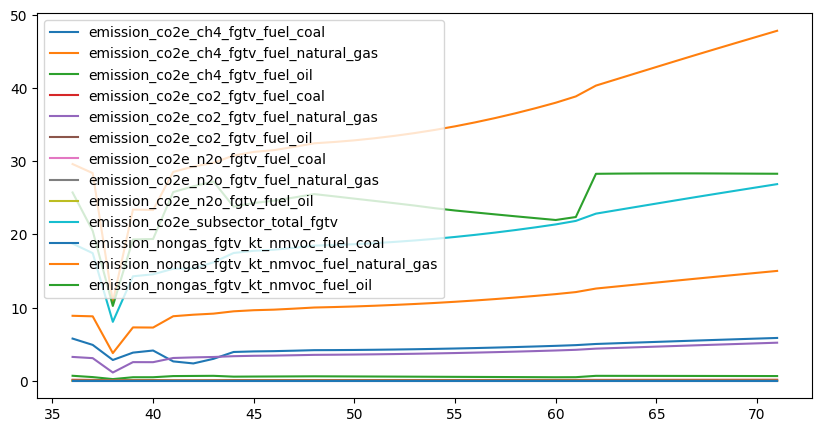

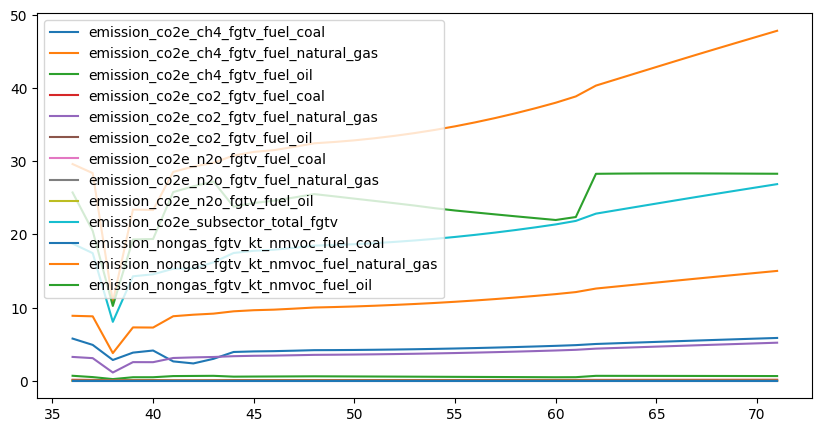

In [88]:
## Fix FGTV when having super large spikes (Only use when there are spikes)
primary_id_to_fix = 72072
df_out[df_out.primary_id==primary_id_to_fix][[col for col in df_out.columns if 'fgtv' in col]].plot(figsize=(10,5))

def hampel_clean(
    s: pd.Series,
    window: int = 7,
    n_sigmas: float = 5.0,
    strategy: str = "prev",  # "prev" | "median" | "linear" | "nan"
):
    """
    Detects spikes using a rolling median + MAD (Hampel) and replaces them.

    Returns
    -------
    cleaned : pd.Series
    mask : pd.Series[bool]  # True where a spike was found
    """
    s = s.astype(float).copy()

    # Rolling median
    med = s.rolling(window, center=True, min_periods=max(3, window//2)).median()

    # Rolling MAD (median absolute deviation)
    def _mad(x):
        m = np.median(x)
        return np.median(np.abs(x - m))
    mad = s.rolling(window, center=True, min_periods=max(3, window//2)).apply(_mad, raw=False)

    # Robust z-score using MAD (~= std when multiplied by 1.4826)
    sigma = 1.4826 * mad
    # Fallbacks at edges
    med = med.fillna(s.median())
    sigma = sigma.replace(0, np.nan).fillna(sigma[sigma>0].median() or 1.0)

    z = (s - med).abs() / sigma
    mask = z > n_sigmas  # spike locations (True = spike)

    # Impute
    cleaned = s.copy()
    if strategy == "prev":
        # copy previous *valid* value
        # (for first element or consecutive spikes, fall back to local median)
        for idx in np.where(mask)[0]:
            if idx > 0 and not np.isnan(cleaned.iloc[idx-1]):
                cleaned.iloc[idx] = cleaned.iloc[idx-1]
            else:
                cleaned.iloc[idx] = med.iloc[idx]
    elif strategy == "median":
        cleaned[mask] = med[mask]
    elif strategy == "linear":
        tmp = cleaned.copy()
        tmp[mask] = np.nan
        cleaned = tmp.interpolate(method="linear", limit_direction="both")
    elif strategy == "nan":
        cleaned[mask] = np.nan
    else:
        raise ValueError("Unknown strategy")

    return cleaned, mask

# --- Example on your Series s ---
# s_clean, spike_mask = hampel_clean(s, window=7, n_sigmas=5.0, strategy="prev")

# select the subset
subset = df_out[df_out.primary_id == primary_id_to_fix].copy()

# get only the relevant columns
cols = [c for c in df_out.columns if 'fgtv' in c]

# make a copy to store cleaned results
cleaned_subset = subset.copy()
spike_masks = {}

# apply Hampel cleaning to each relevant column
for c in cols:
    cleaned_subset[c], spike_masks[c] = hampel_clean(
        subset[c],
        window=7,
        n_sigmas=5.0,
        strategy="prev"  # or "median"/"linear"
    )

# if you want to merge back into df_out:
df_out.loc[df_out.primary_id == primary_id_to_fix, cols] = cleaned_subset[cols]
df_out[df_out.primary_id==primary_id_to_fix][[col for col in df_out.columns if 'fgtv' in col]].plot(figsize=(10,5))

In [89]:
# Define the fields to plot and the formatting dictionary
subsector_emission_fields = matt.get_all_subsector_emission_total_fields()

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

In [90]:
primary_ids_to_plot = df_out[ssp.key_primary].unique()
primary_ids_to_plot

array([    0, 72072, 73073, 74074])

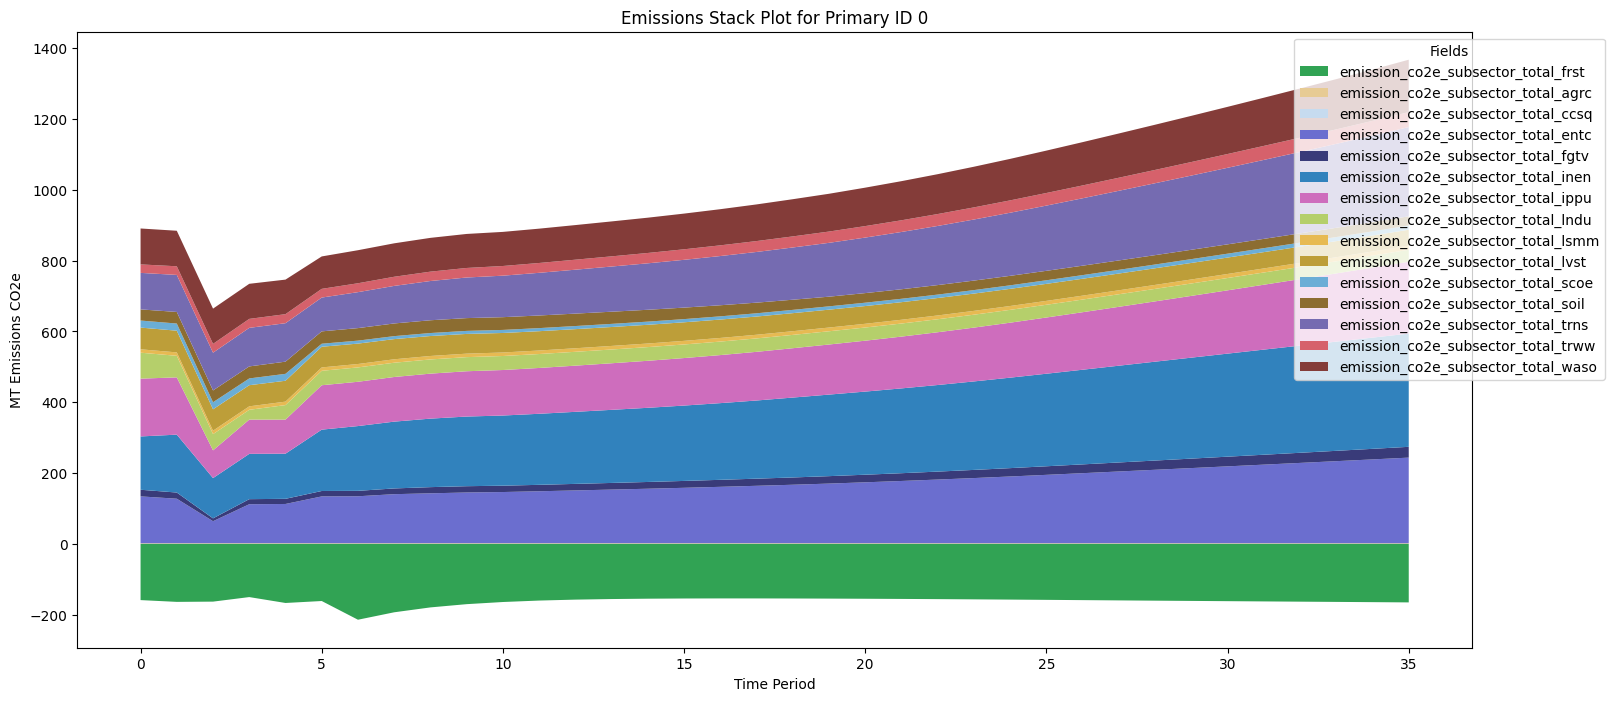

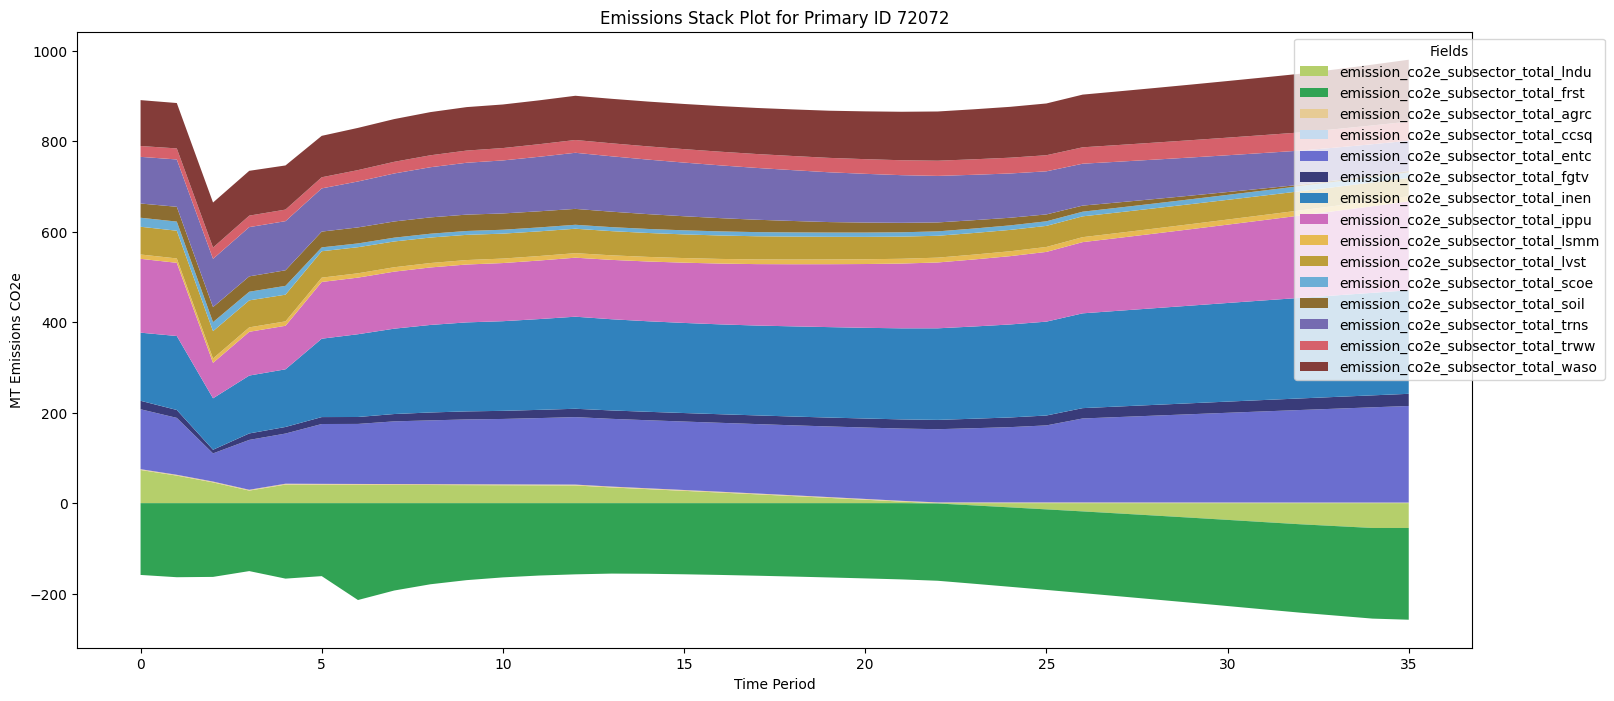

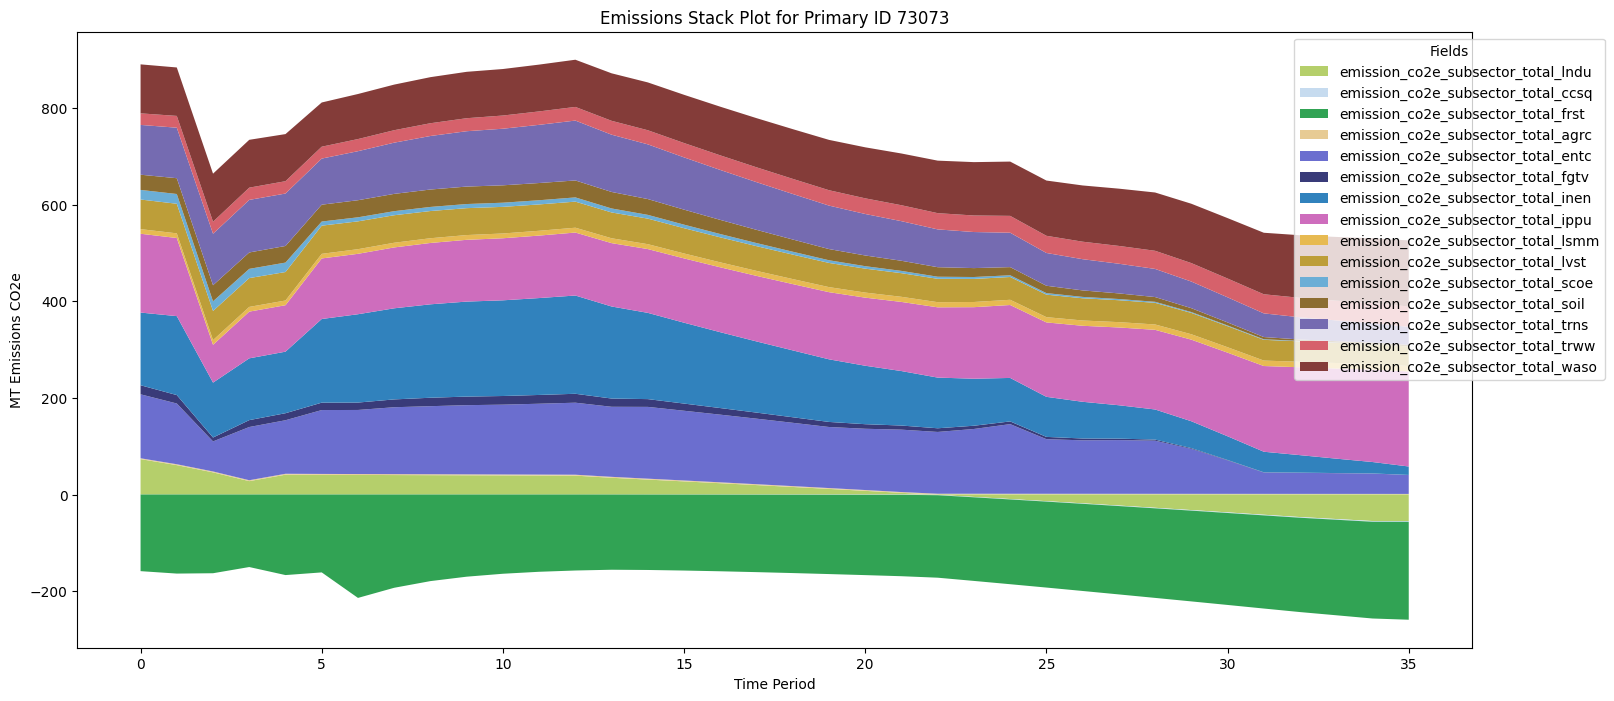

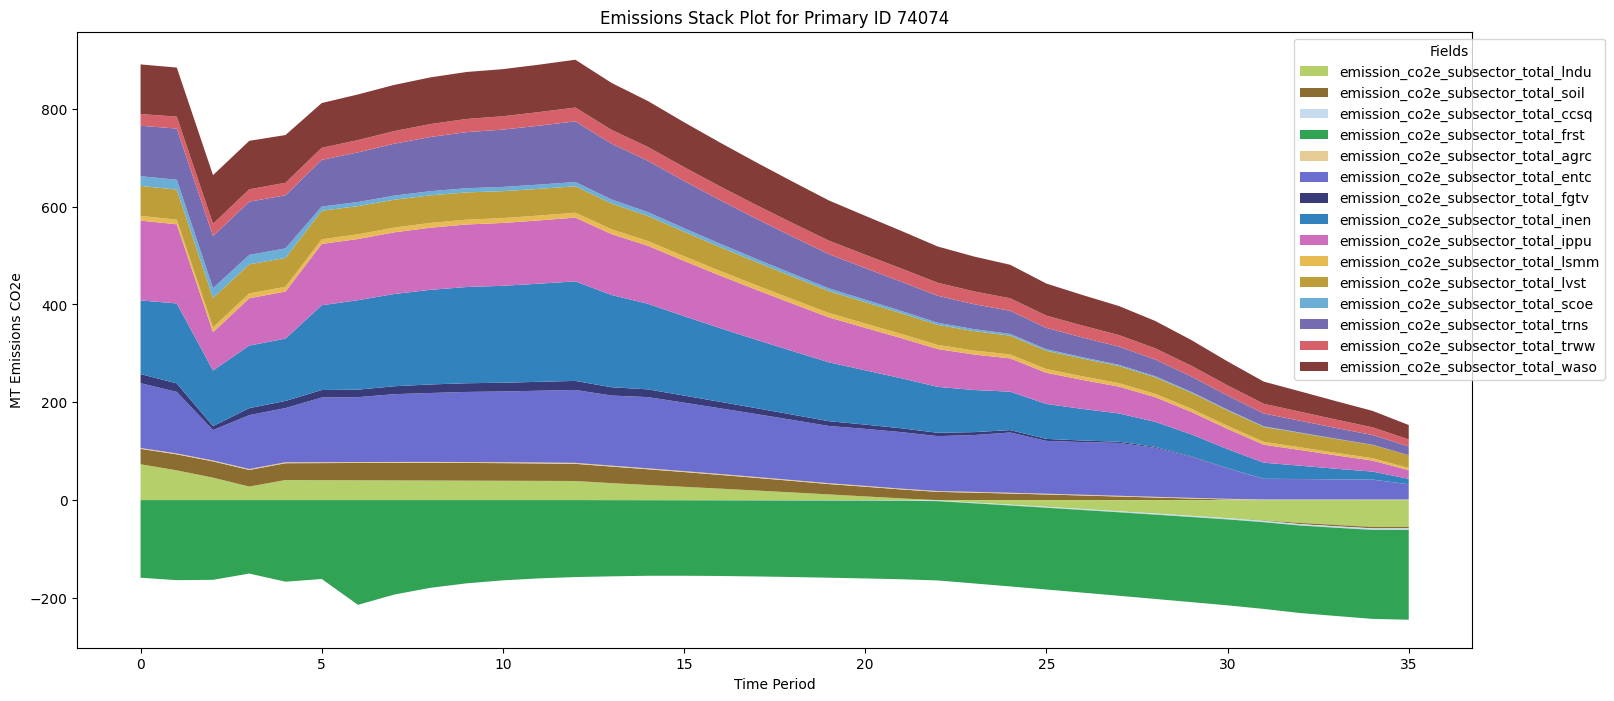

In [91]:
# Plot the emissions stack for the primary_id 0 (which is the baseline)
for primary_id in primary_ids_to_plot:

    plot_field_stack(
        df_out,
        subsector_emission_fields,
        dict_format,
        primary_id=primary_id,
        title=f"Emissions Stack Plot for Primary ID {primary_id}"
    )

# Export Wide File (Last Mandatory Step)

In [92]:
all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [93]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/Users/fabianfuentes/anaconda3/envs/ssp_mexico_nm/lib/python3.11/site-packages/sisepuede/out'

In [94]:
RUN_ID_OUTPUT_DIR_PATH = os.path.join(
    RUN_OUTPUT_DIR_PATH, 
    f"sisepuede_results_{ssp.id_fs_safe}"
)

os.makedirs(RUN_ID_OUTPUT_DIR_PATH, exist_ok=True)

df_primary.to_csv(
    os.path.join(RUN_ID_OUTPUT_DIR_PATH, "ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        logger.warning(f"Warning: Table {tab} returned None.")

In [95]:
tableau_levers_table_csv.to_csv(
            os.path.join(RUN_ID_OUTPUT_DIR_PATH, "tableau_levers_table.csv"),
            index=None,
            encoding="UTF-8"
        )

In [96]:
RUN_ID_OUTPUT_DIR_PATH

'/Users/fabianfuentes/git/ssp_mexico/ssp_modeling/ssp_run_output/sisepuede_results_sisepuede_run_2025-11-27T17;11;59.710775'

In [97]:
# gdp_df = df_in[["time_period", "gdp_mmm_usd"]].copy()
# gdp_df["year"] = gdp_df["time_period"] + 2015
# gdp_df = gdp_df.drop(columns=["time_period"])
# gdp_df.head()